In [126]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
#sns.set()

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier
from xgboost import plot_importance


# Data Loading

In [127]:
data_path = 'data_for_classification.csv'
df = pd.read_csv(data_path)
df_raw = df.copy()
df.head()

,Patient_ID,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition
0,1,0.549671,6.463089,1.026997,0,64,Male,81.913568,9.099271,1
1,2,0.486174,6.954708,1.024623,0,51,Female,97.284908,9.665405,1
2,3,0.564769,5.300716,1.020298,0,67,Female,95.883400,9.347795,0
3,4,NaN,6.281485,1.016765,0,41,Female,NaN,9.621079,0
4,5,0.476585,5.674679,1.023491,0,23,Female,96.926143,9.143055,0


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Patient_ID        500 non-null    int64  
 1   Protein           450 non-null    float64
 2   pH                450 non-null    float64
 3   Specific_Gravity  450 non-null    float64
 4   Blood             500 non-null    int64  
 5   Age               500 non-null    int64  
 6   Gender            500 non-null    object 
 7   Glucose           450 non-null    float64
 8   Calcium           500 non-null    float64
 9   Condition         500 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 39.2+ KB


_There are 4 columns in the dataset (Protein, pH, Specific_Gravity, Glucose) that have 50 missing values each. Besides these, the dataset is complete._

_To enhance readability and analysis, we'll reorder the columns as follows: demographic information, urine analysis metrics and target variable._

In [129]:
# reorder columns
old_cols = df.columns.values 
new_cols= ['Patient_ID', 'Age', 'Gender', 'Protein', 'pH', 'Specific_Gravity', 'Glucose', 'Calcium', 'Blood', 'Condition']	
df = df.reindex(columns=new_cols)

In [130]:
df.describe()

,Patient_ID,Age,Protein,pH,Specific_Gravity,Glucose,Calcium,Blood,Condition
count,500.000000,500.000000,450.000000,450.000000,450.000000,450.000000,500.000000,500.000000,500.000000
mean,250.500000,49.588000,0.508933,6.012429,1.020651,102.181502,9.483070,0.090000,0.272000
std,144.481833,16.978893,0.119752,0.487001,0.004984,17.734595,0.485876,0.286468,0.445436
min,1.000000,20.000000,0.175873,4.651557,1.005519,56.065730,7.880281,0.000000,0.000000
25%,125.750000,36.000000,0.431103,5.695183,1.017187,92.461187,9.153320,0.000000,0.000000
50%,250.500000,50.000000,0.500912,6.014519,1.020599,101.411773,9.506763,0.000000,0.000000
75%,375.250000,64.000000,0.566074,6.322397,1.023795,112.096626,9.813687,0.000000,1.000000
max,500.000000,79.000000,1.235859,7.316191,1.032899,183.473858,10.764782,1.000000,1.000000


_The data appears to be clean, values are all positive, as expected for these data._

In [131]:
# identify groups of columns

data_cols = df.columns.difference(['Patient_ID', 'Condition']).tolist()
numeric_cols = [col for col in df[data_cols].select_dtypes(include=['float64', 'int64']).columns 
                if df[col].nunique() > 2]
categorical_cols = list(set(data_cols) - set(numeric_cols))
nans_cols = [col for col in data_cols if df[col].isnull().any()]

print("Numeric Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)
print("Columns with Missing Values:", nans_cols)


Numeric Columns: ['Age', 'Calcium', 'Glucose', 'Protein', 'Specific_Gravity', 'pH']
Categorical Columns: ['Blood', 'Gender']
Columns with Missing Values: ['Glucose', 'Protein', 'Specific_Gravity', 'pH']


In [132]:
# for plotting

def random_palette():
    return sns.color_palette([np.random.rand(3,) for _ in range(2)])

def random_color():
    return np.random.uniform(0.3, 0.7, 3)

target_palette = ['orange', 'purple']

# Data Preprocessing

### Gender encoding

_Turn the `Gender` column into a binary column using one-hot encoding._

In [133]:
# one-hot encodeing the 'Gender' column
gender_ohe = pd.get_dummies(df['Gender'])
df = df.drop(['Gender'],axis=1)
df['Gender'] = gender_ohe['Male']
df.head()

,Patient_ID,Age,Protein,pH,Specific_Gravity,Glucose,Calcium,Blood,Condition,Gender
0,1,64,0.549671,6.463089,1.026997,81.913568,9.099271,0,1,True
1,2,51,0.486174,6.954708,1.024623,97.284908,9.665405,0,1,False
2,3,67,0.564769,5.300716,1.020298,95.883400,9.347795,0,0,False
3,4,41,NaN,6.281485,1.016765,NaN,9.621079,0,0,False
4,5,23,0.476585,5.674679,1.023491,96.926143,9.143055,0,0,False


### Missing values

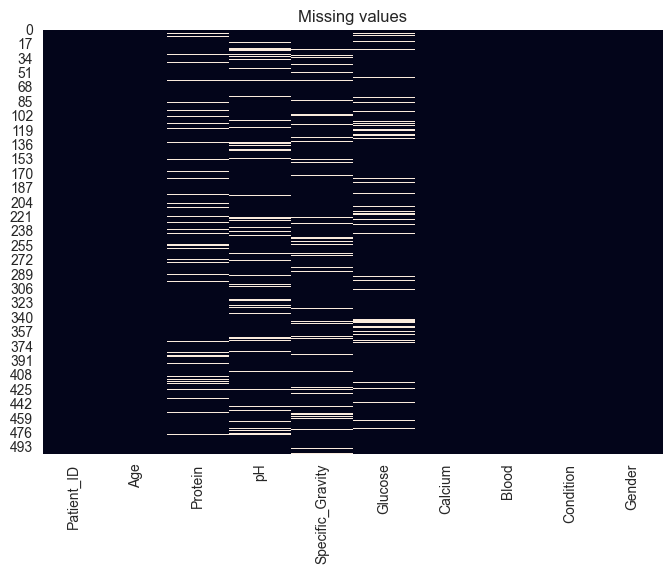

In [134]:
# visualize missing values with a heatmap
sns.heatmap(df.isnull(), cbar=False)
plt.title(f"Missing values")
plt.show()

_Missing values appear to be random. Next, let's investigate if these missing values are correlated with other columns to determine if regression or other methods can be used for imputation._

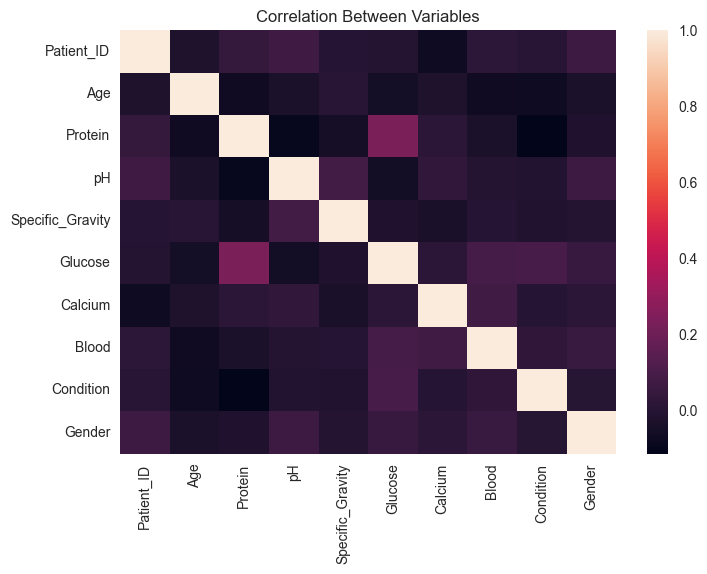

In [135]:
# visualize the correlation in the data 
corr_matrix =df.corr(numeric_only=True)
sns.heatmap(corr_matrix)
plt.title(f"Correlation Between Variables")
plt.show()

_Correlation values are low, indicating that the missing values are not strongly correlated with other features. Therefore, it would be appropriate to fill the missing values using median or mean imputation. Let's examine the distribution of the data to make an informed decision on whether to use the median or mean for imputation._

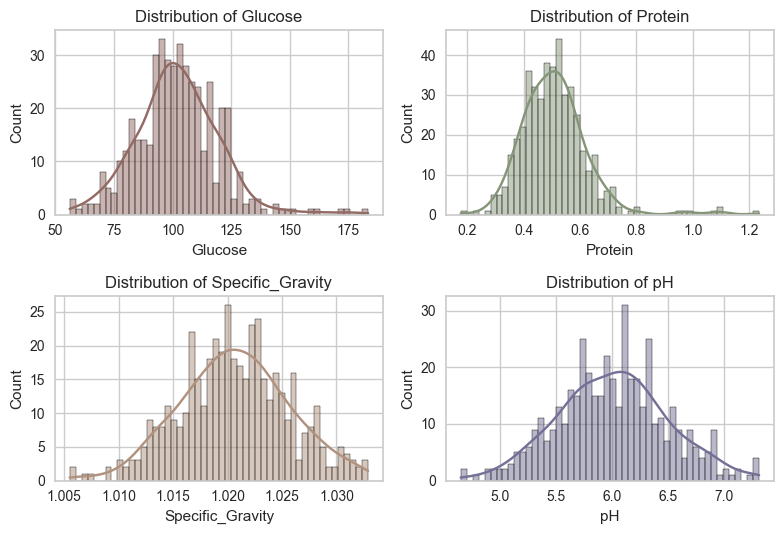

In [136]:
# plot the distribution of columns with missing values

plt.figure()
for i, col in enumerate(nans_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=50, color=random_color())
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

_The data distributions are mostly skewed, indicating that the median is a more appropriate measure of central tendency for imputing missing values. Therefore, we'll fill the missing values with the median for each column._

In [137]:
# fill missing values with the median
df = df.fillna(df.median(numeric_only=True))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Patient_ID        500 non-null    int64  
 1   Age               500 non-null    int64  
 2   Protein           500 non-null    float64
 3   pH                500 non-null    float64
 4   Specific_Gravity  500 non-null    float64
 5   Glucose           500 non-null    float64
 6   Calcium           500 non-null    float64
 7   Blood             500 non-null    int64  
 8   Condition         500 non-null    int64  
 9   Gender            500 non-null    bool   
dtypes: bool(1), float64(5), int64(4)
memory usage: 35.8 KB


### Outliers detection

_We will detect outliers in the numeric columns using the Interquartile Range (IQR) method._


In [138]:
# detect outliers
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR)))
outliers_count = outliers.sum()
print(outliers_count)

Age                  0
Calcium              4
Glucose             21
Protein             13
Specific_Gravity     9
pH                   9
dtype: int64


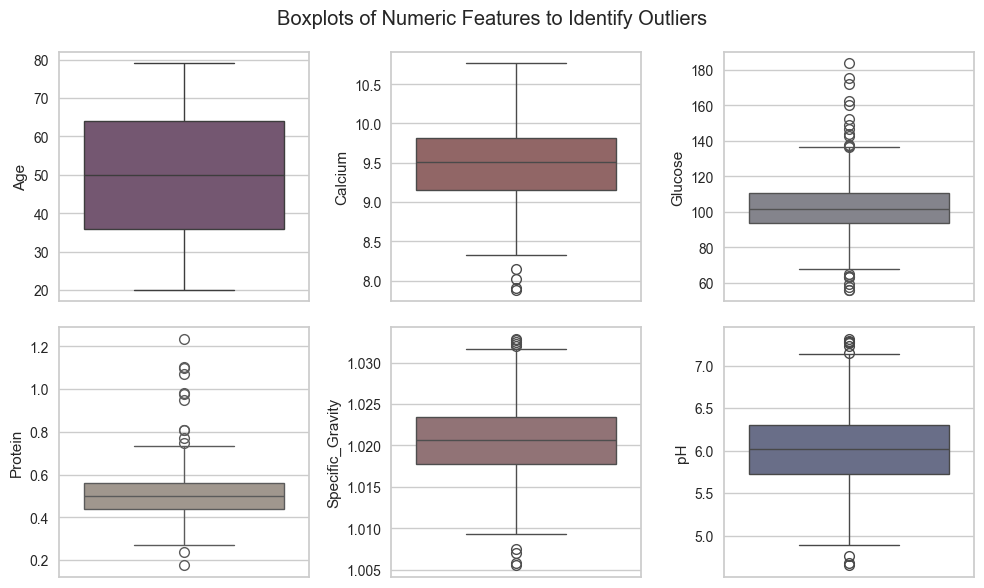

In [139]:
# plot boxplots for numeric column to visulize outliers

fig, axes = plt.subplots(2, 3, figsize=(10, 6)) 

for i, ax in enumerate(axes.flatten()): 
    sns.boxplot(data=df, y=numeric_cols[i], ax=ax, color=random_color())
plt.suptitle("Boxplots of Numeric Features to Identify Outliers")
plt.tight_layout()
plt.show()

_Protein and glucose show  outliers. Specific Gravity and calcium have a few lower outliers. pH has outliers near the edges, while age has none. However, these Outliers are within the normal or expected range for urine analysis and may hold important clinical information, so we will not remove them._

# Exploratory Data Analysis (EDA)

In [140]:
print(f"number of unique IDs: {len(np.unique(df['Patient_ID']))}")

number of unique IDs: 500


_There are no repeated patients, if there were repetitions, we would need to address that during data splitting._

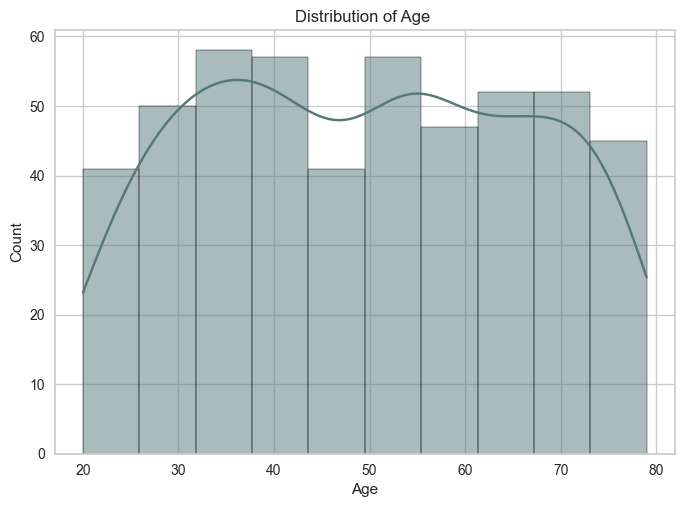

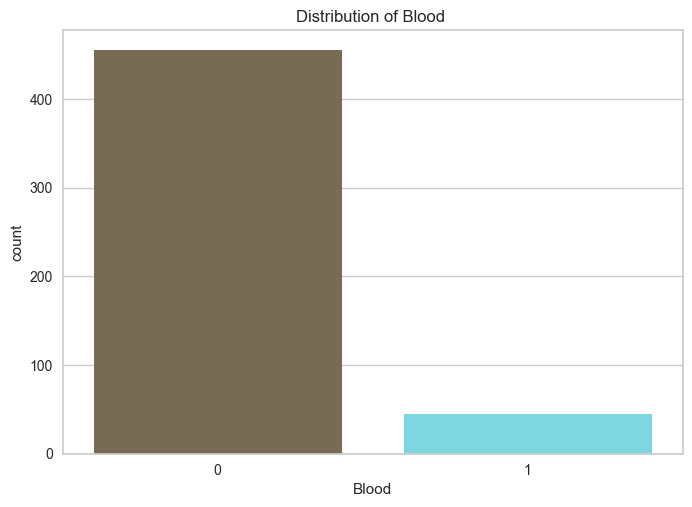

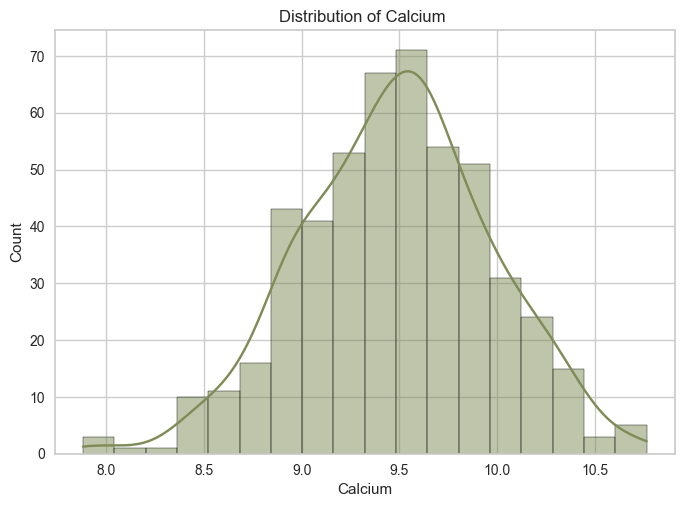

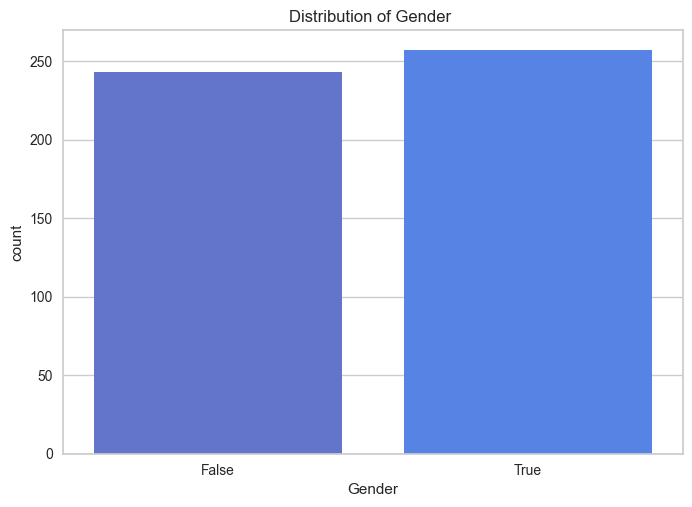

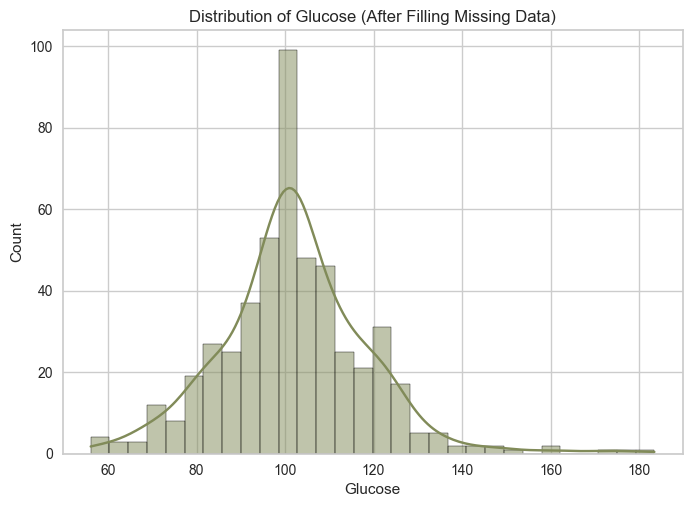

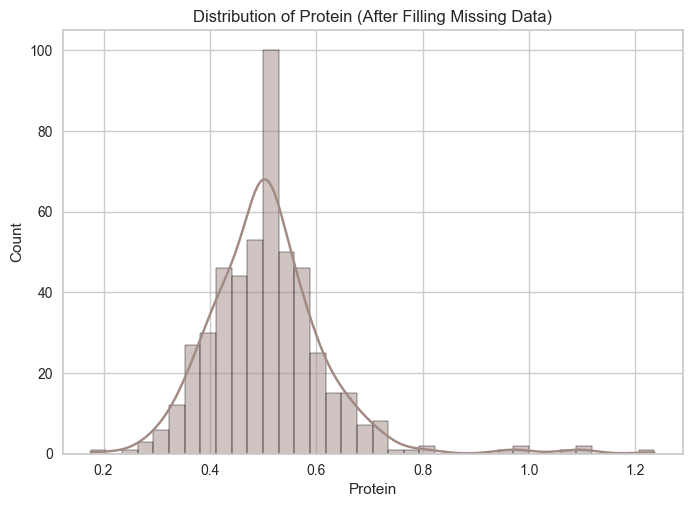

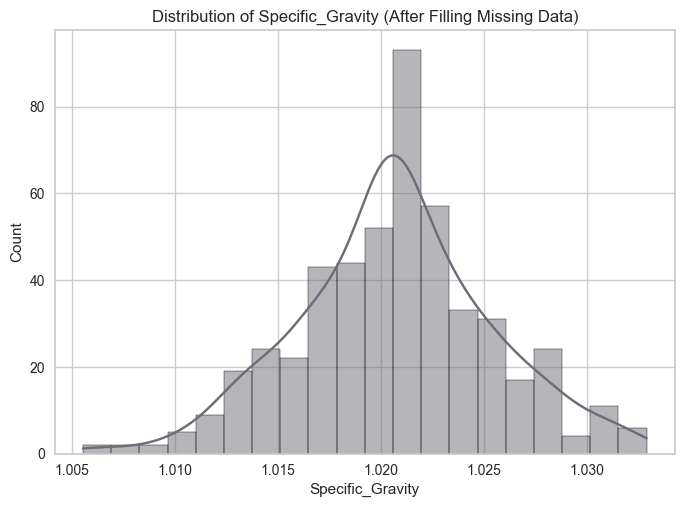

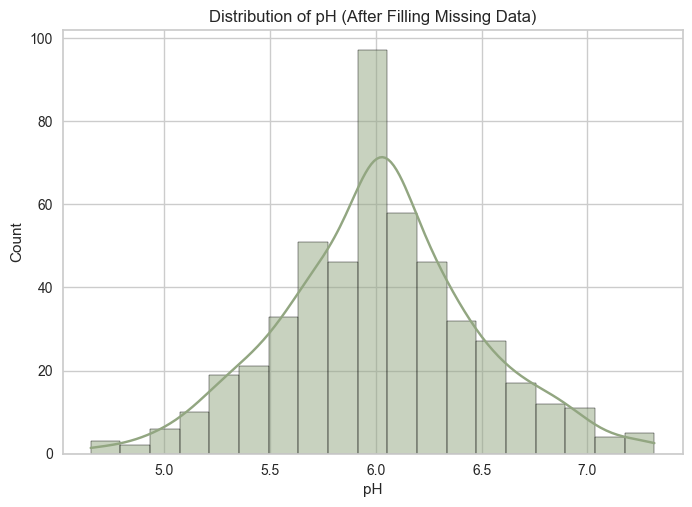

In [141]:
# plot data according to the type

for col in data_cols:

    title_missing = ""
    if col in nans_cols:
        title_missing = "(After Filling Missing Data)"
    
    if col in categorical_cols: 
        sns.countplot(x=df[col], palette=random_palette())
    else:
        sns.histplot(df[col], kde=True, color=random_color())
    plt.title(f"Distribution of {col} {title_missing}")
    plt.show()

_The plots reveal that numerical data shows a skewed distribution, the blood data is mostly zero, and the gender distribution is balanced._

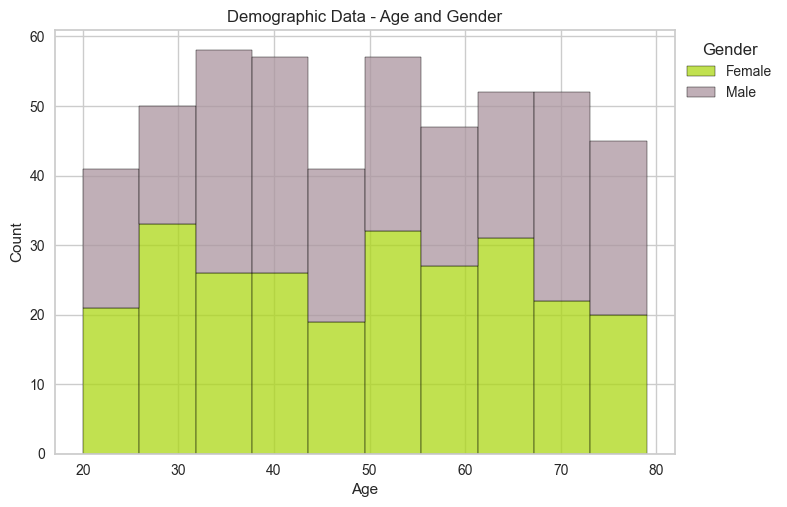

In [142]:
# plot demographic data 
sns.histplot(df, x='Age', hue='Gender', multiple='stack', palette=random_palette())
plt.title("Demographic Data - Age and Gender")
plt.legend(title="Gender", labels=["Female", "Male"], bbox_to_anchor=(1,1))
plt.show()

_No interesting pattern emerges from the demographic information._

### Target analysis

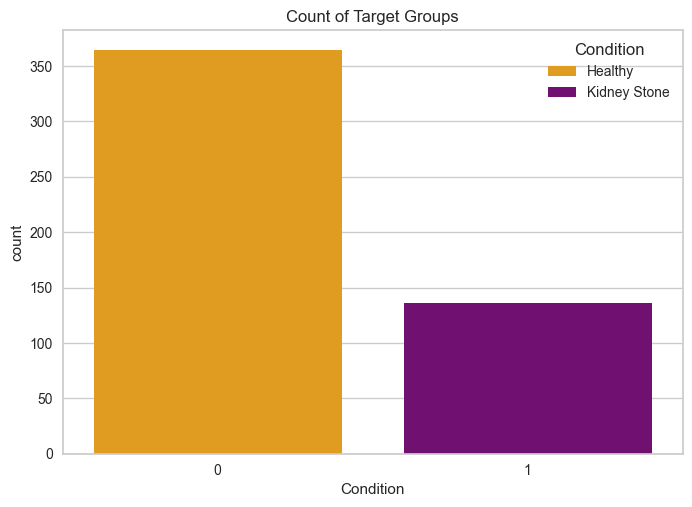

In [143]:
# target distribution 

sns.countplot(x='Condition', hue='Condition', data=df, palette=target_palette)
plt.title("Count of Target Groups")
plt.legend(title="Condition", labels=["Healthy", "Kidney Stone"], bbox_to_anchor=(1,1))
plt.show()

_The target classes are imbalanced, with the healthy class having significantly more examples than the kidney stone class._

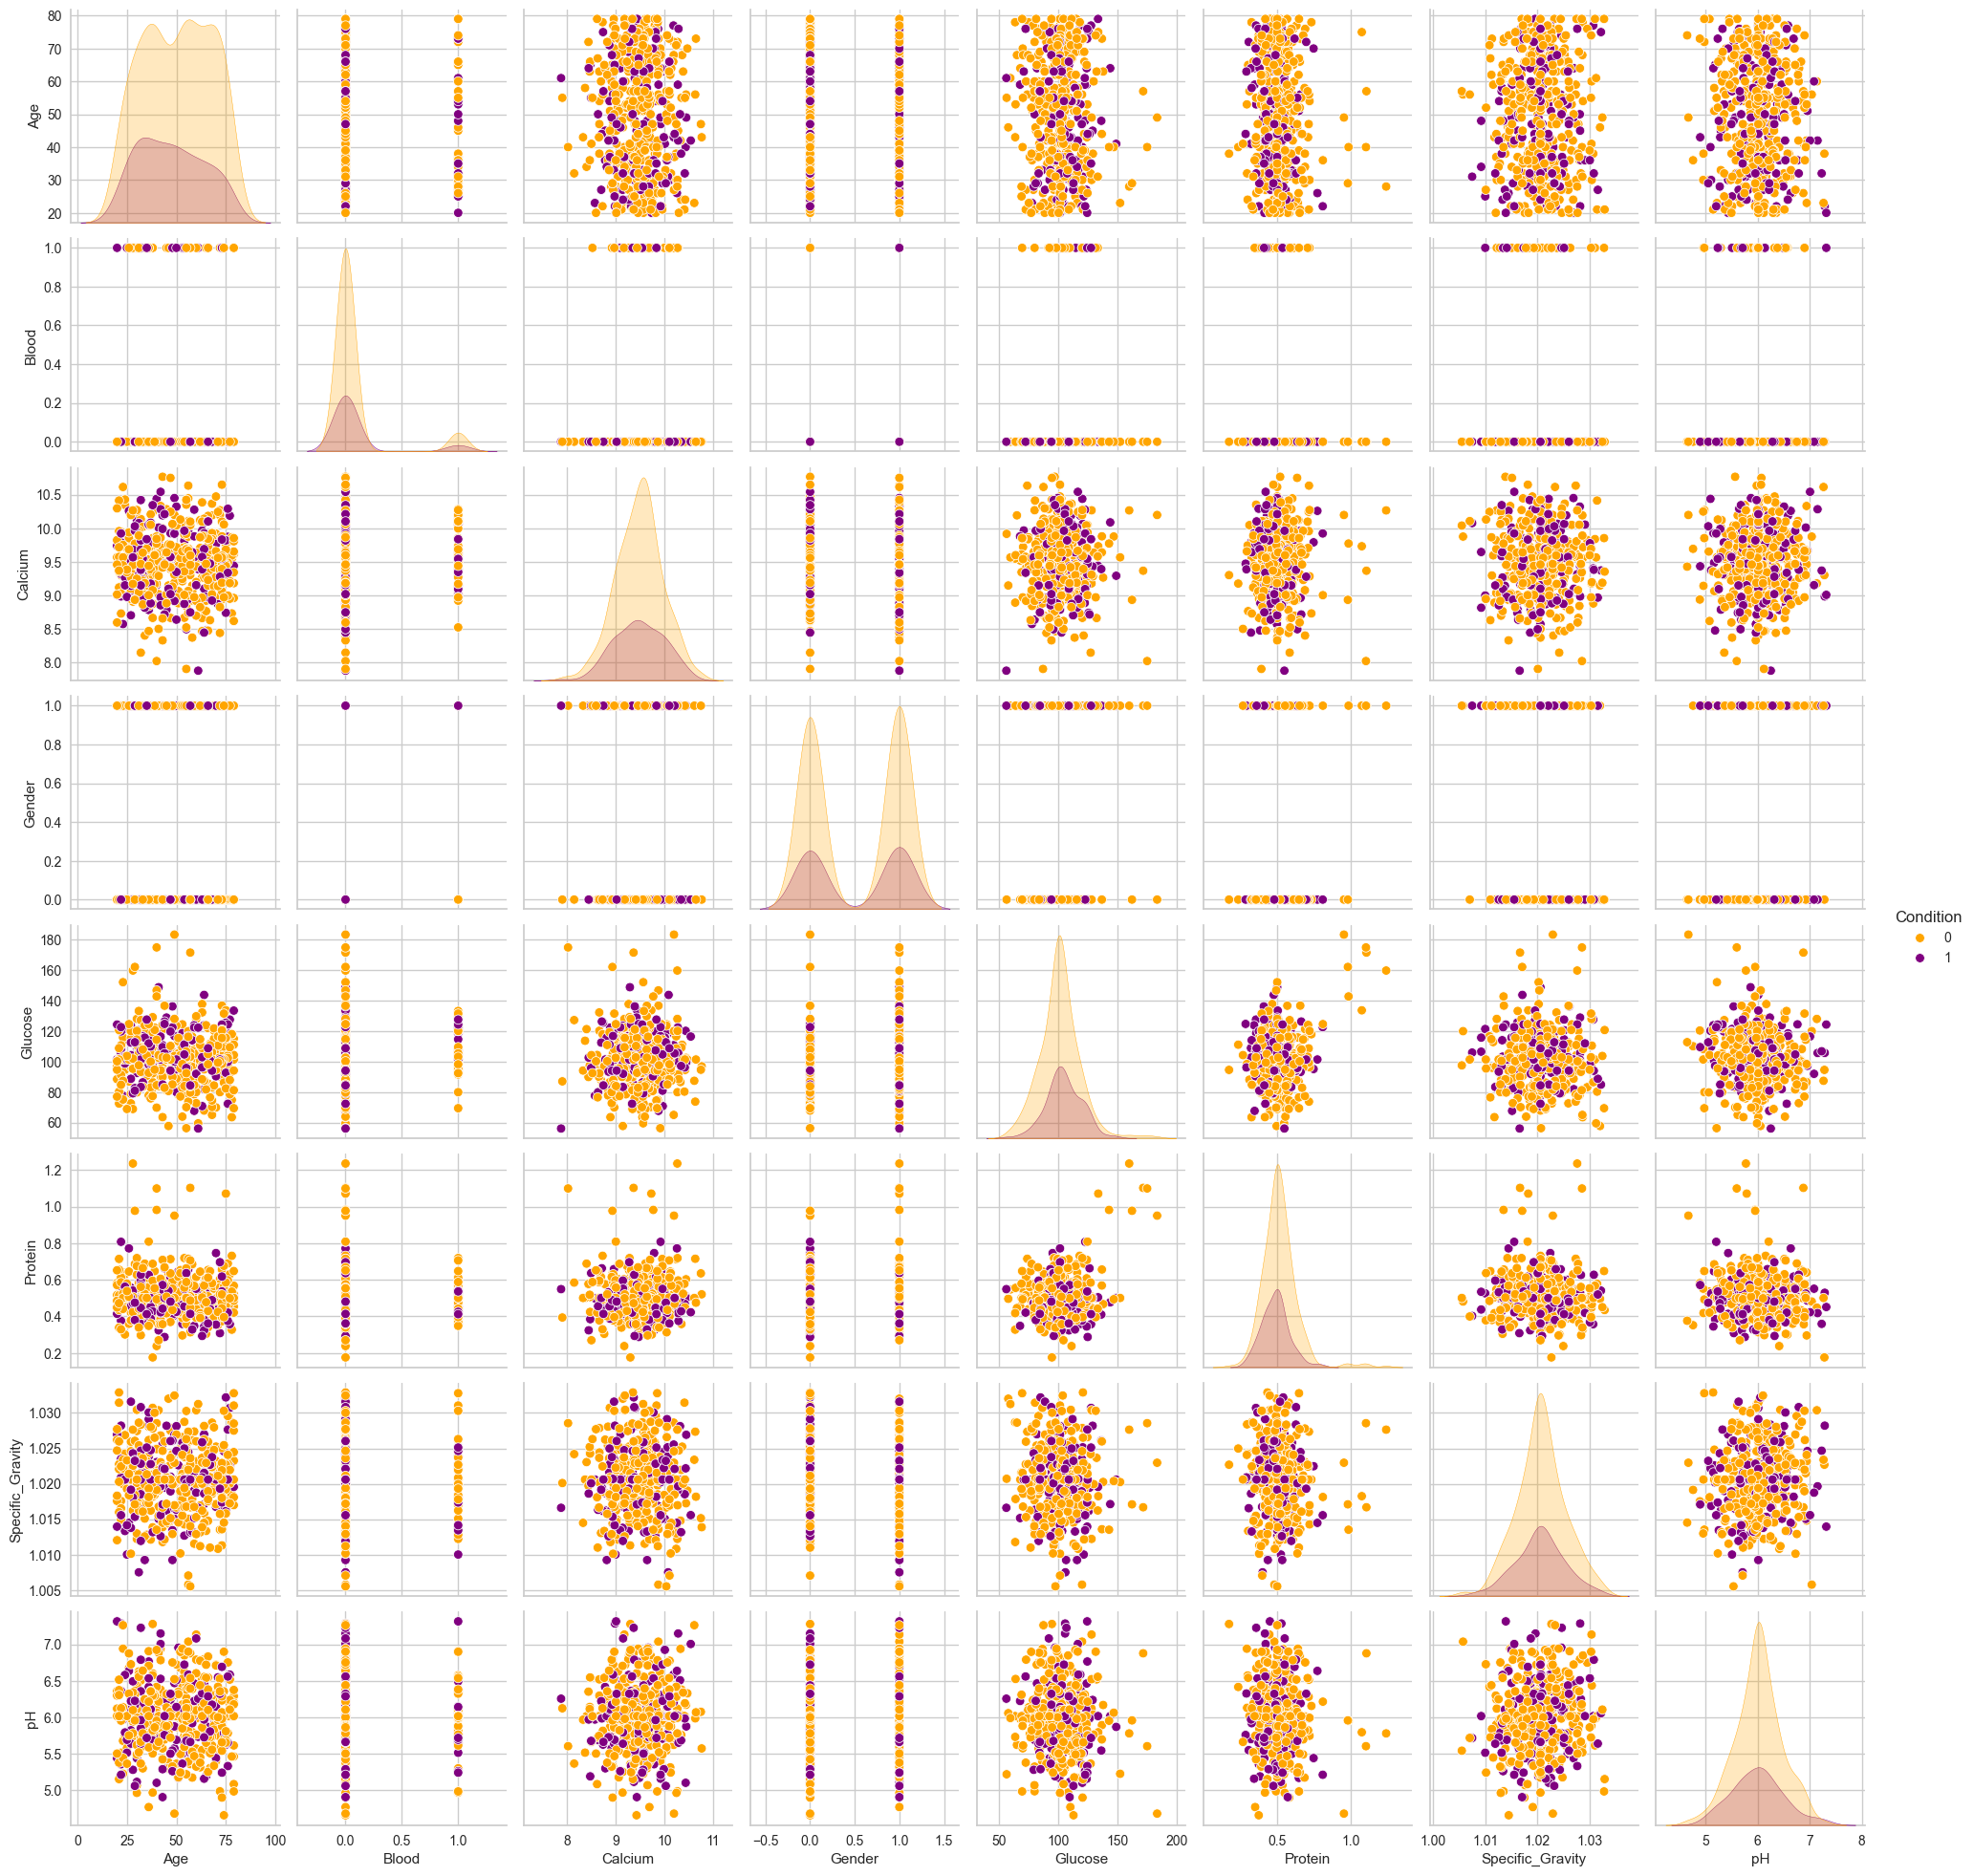

In [144]:
data_pair = data_cols + ['Condition']
sns.pairplot(df[data_pair], hue="Condition",  palette=target_palette)

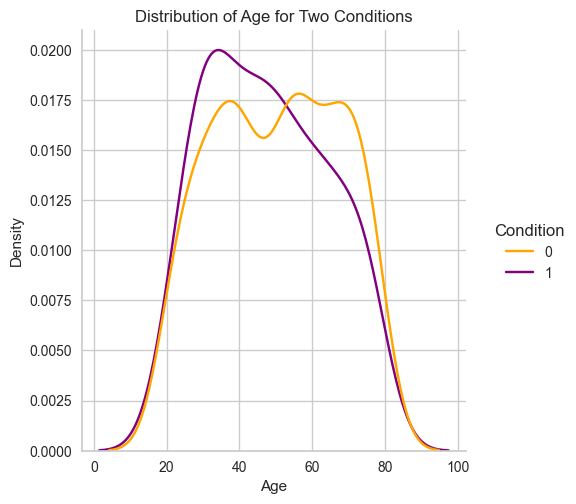

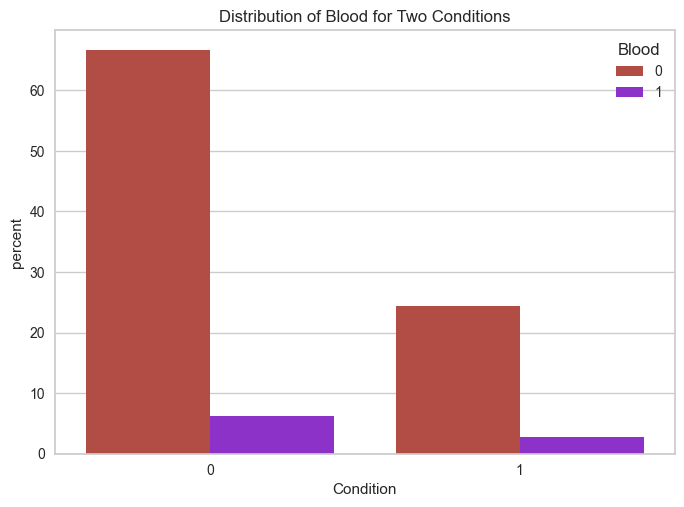

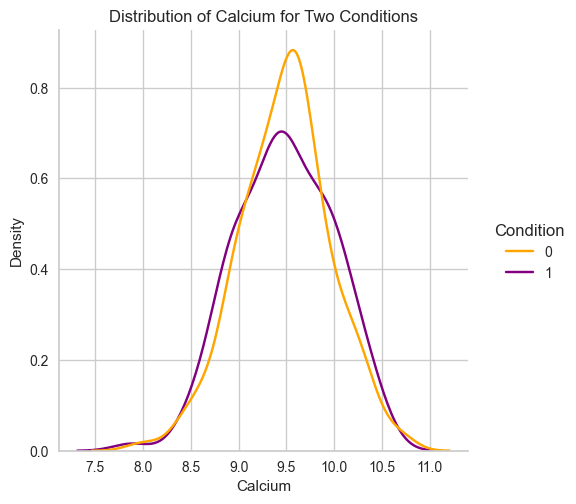

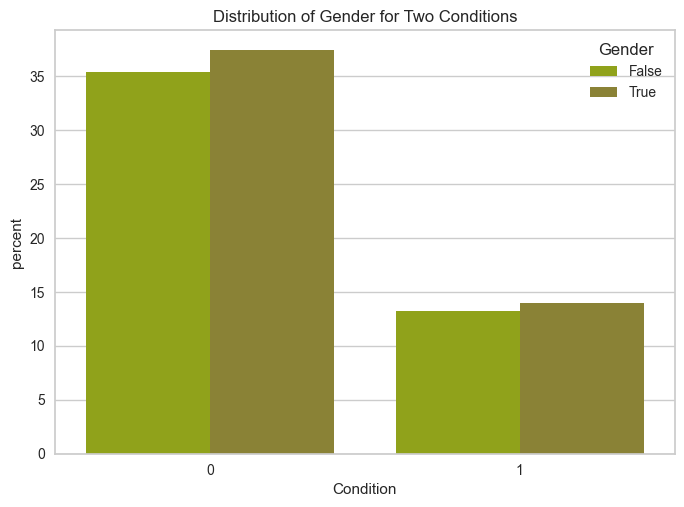

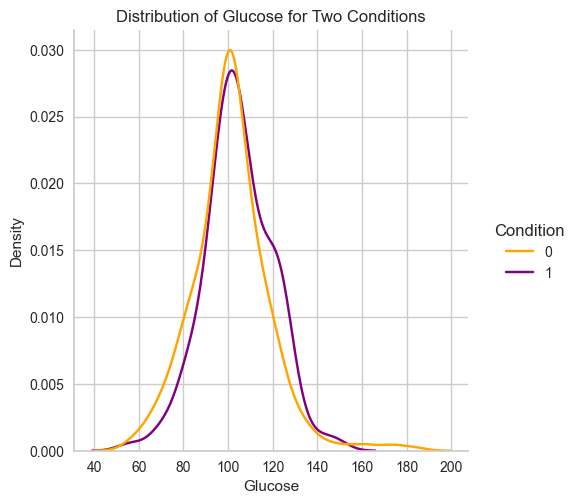

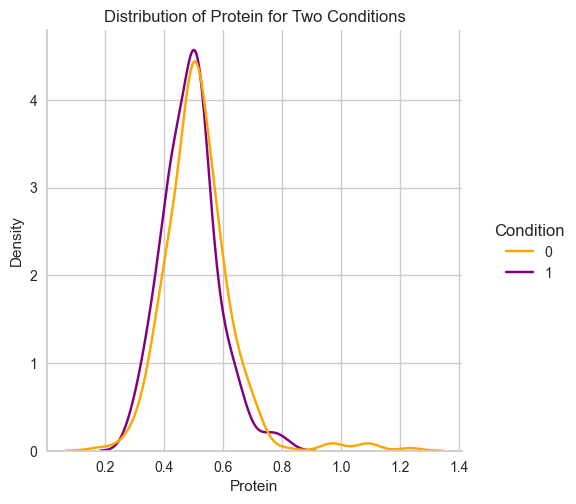

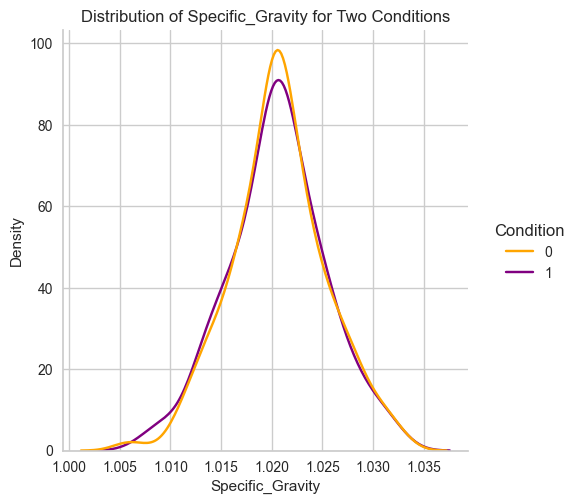

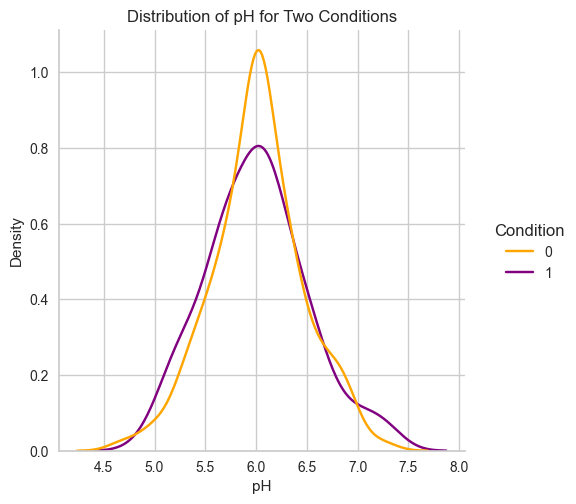

In [145]:
# plot disribution of data for two conditions 

for col in data_cols:
    
    if col in categorical_cols: 
        sns.countplot(x='Condition', hue=col, data=df, stat='percent', palette=random_palette())
    else:
        sns.displot(df, x=col, hue='Condition', kind='kde', common_norm=False, palette=target_palette)
    plt.title(f"Distribution of {col} for Two Conditions")
    plt.show()

_Distributions across both conditions are quite similar._

### Feature Engineering

_Let's create new features to capture important interactions between variables._

In [146]:
def plot_new_feature(feature1, feature2, new_feature):
    sns.displot(df, x=new_feature, hue='Condition', kind='kde', 
                common_norm=False, palette=target_palette)
    plt.title(f"Distribution of {feature1} & {feature2} Interaction for Two Conditions")
    plt.show()

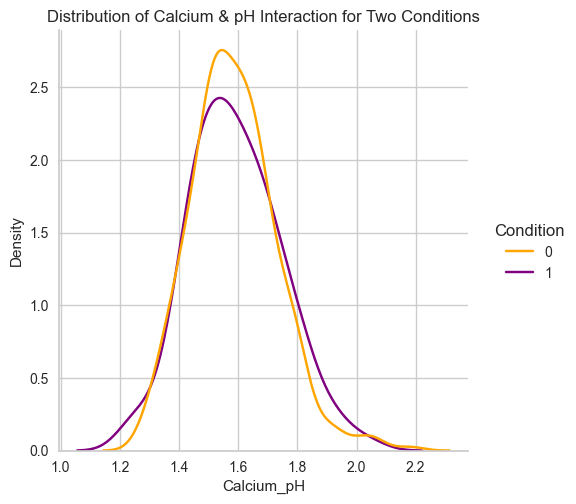

In [147]:
# interaction between Calcium and pH levels: this may reveal ranges where the risk of kidney stones increases.
df['Calcium_pH'] =  df['Calcium'] / df['pH'] 
plot_new_feature('Calcium', 'pH', 'Calcium_pH')

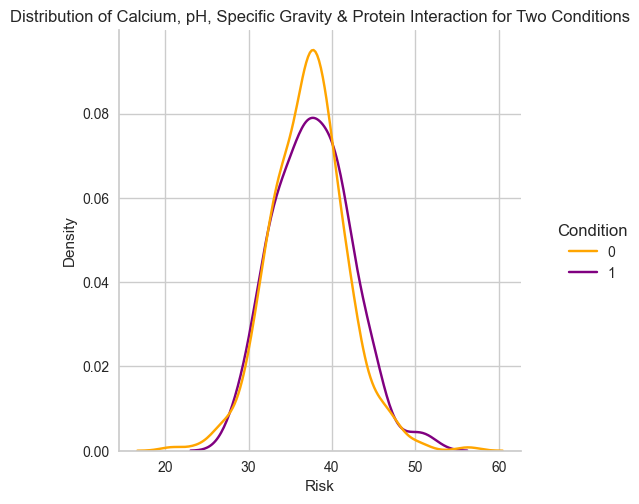

In [148]:

# risk feature that combines Calcium, pH, Specific Gravity, and Protein levels, a more complex interaction that could be indicative of kidney stone risk.
df['Risk'] =  (df['Calcium'] * df['pH']) / (df['Specific_Gravity'] * (df['Protein'] + 1))
plot_new_feature('Calcium, pH, Specific Gravity', 'Protein', 'Risk')

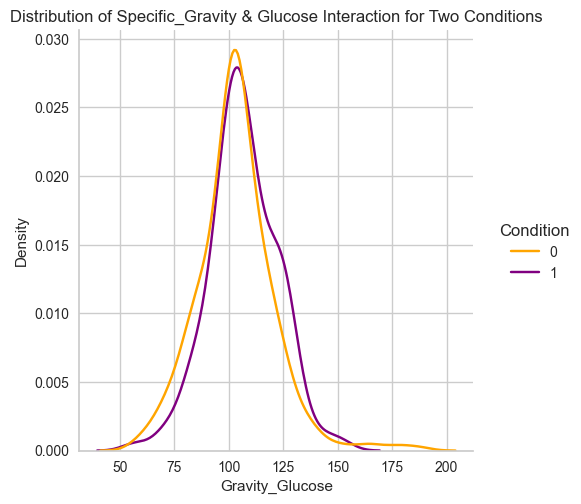

In [149]:
# interaction between Specific Gravity and Glucose levels: when both increase, it may indicate a higher risk for kidney stones.
df['Gravity_Glucose'] =   df['Specific_Gravity'] * df['Glucose'] 
plot_new_feature('Specific_Gravity', 'Glucose', 'Gravity_Glucose')

### Feature Selection

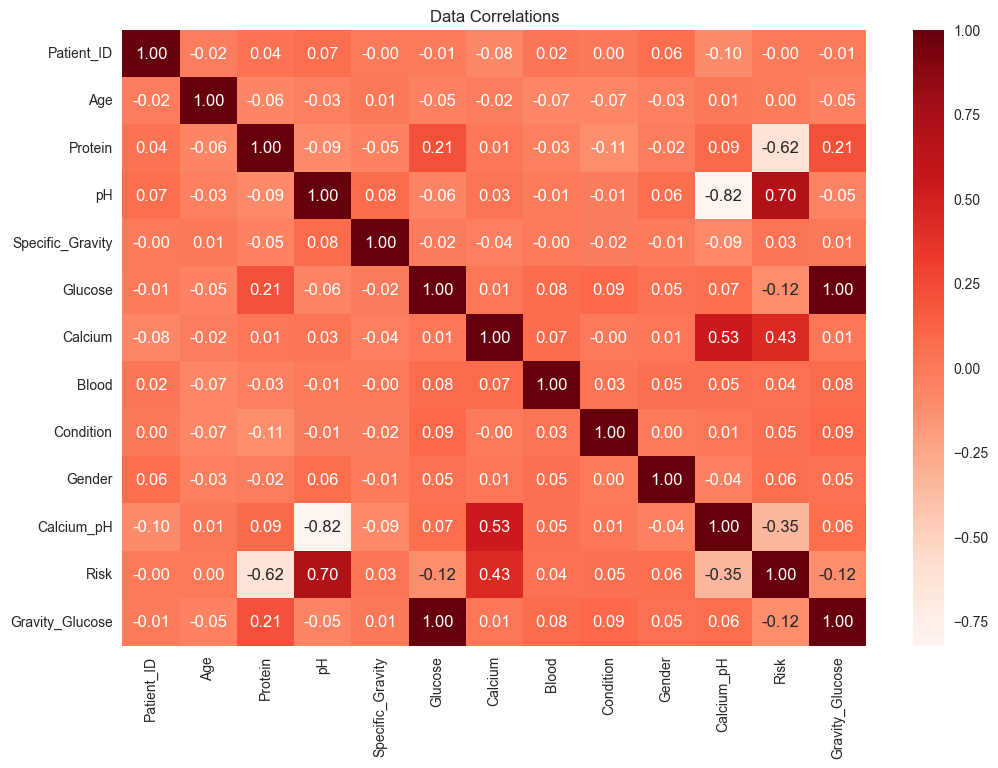

In [150]:
# plot the correlation matrix to identify correlated features for potential feature selection
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix,  annot=True, fmt=".2f", cmap=plt.cm.Reds)
plt.title('Data Correlations')
plt.show()

_Gravity_Glucose is perfectly correlated with Glucose (correlation = 1), so we'll remove it to avoid redundancy._

In [151]:
# remove correlated column 
df = df.drop(['Gravity_Glucose'],axis=1)

# DataHandler Class

_The class is designed based on the EDA and analysis steps performed here. However, it is not used in this phase to maintain the flexibility needed during exploration._

In [152]:
class DataHandler:
    def __init__(self, data=None, numeric=None, categorical=None, target=None):
        """
        Initialize the DataHandler object.
        
        Parameters:
        data (DataFrame): The dataset.
        numeric (list): List of numeric columns.
        categorical (list): List of categorical columns.
        target (str): The target column.
        """
        self.data = data
        self.numeric = numeric
        self.categorical = categorical
        self.target = target

    def load_data(self, path, target):
        """
        Load the dataset from a CSV file and set the target column.
        
        Parameters:
        path (str): The file path to the CSV.
        target (str): The target column name.
        """
        self.data = pd.read_csv(path)
        self.target = target
        self.get_columns() 
    
    def get_info(self):
        """
        Print information about the dataset.
        """
        return self.data.info()

    def gender_ohe(self):
        """
        Convert the Gender column to a binary column using one-hot encoding.
        """
        gender_ohe = pd.get_dummies(self.data['Gender'])
        self.data.drop(['Gender'], axis=1, inplace=True)
        self.data['Gender'] = gender_ohe['Male']

    def fill_missing_median(self):
        """
        Fill missing values in numeric columns with the median value.
        """
        self.data = self.data.fillna(self.data.median(numeric_only=True))

    def clean_data(self):
        """
        Perform data cleaning by handling gender encoding and filling missing values.
        """
        self.gender_ohe()
        self.fill_missing_median()

    def get_columns(self): 
        """
        Identify and categorize columns into numeric and categorical types.
        """
        id_cols = [col for col in self.data.columns if 'id' in col.lower()]
        non_data = id_cols + [self.target]  
        data_cols = self.data.columns.difference(non_data).tolist()
        self.numeric = [col for col in self.data[data_cols].select_dtypes(include=['float64', 'int64']).columns 
                    if self.data[col].nunique() > 2]
        self.categorical = list(set(data_cols) - set(self.numeric))

    def show_distributions(self):
        """
        Plot the distributions of columns.
        """
        for col in self.categorical: 
            sns.countplot(x=self.target, hue=col, data=self.data, stat='percent', palette=random_palette())
            plt.title(f"Distribution of {col} for Two Conditions")
            plt.show()
        for col in self.numeric:
            sns.displot(self.data, x=col, hue=self.target, kind='kde', common_norm=False, palette=target_palette)
            plt.title(f"Distribution of {col} for Two Conditions")
            plt.show()
    
    def show_outliers(self):
        """
        Plot boxplots to visualize outliers in numeric columns.
        """
        num_cols = len(self.numeric)
        num_rows = (num_cols + 2) // 3
        fig, axes = plt.subplots(num_rows, 3,)
        for i, ax in enumerate(axes.flatten()):
            sns.boxplot(data=self.data, y=self.numeric[i], ax=ax)
        plt.tight_layout()
        plt.suptitle("Boxplots of Numeric Features to Identify Outliers", y=1.02)
        plt.show()

    def feature_engineering(self, new_feature, new_values):
        """
        Create a new feature in the dataset based on provided values.
        
        Parameters:
        new_feature (str): The name of the new feature.
        new_values (Series): The values to assign to the new feature.
        """
        self.data[new_feature] = new_values
    
    def feature_selection_correlation(self, threshold=0.9):
        """
        Remove features that are highly correlated with others in the dataset.
        
        Parameters:
        threshold (float): The correlation threshold above which features are considered highly correlated.
        """
        corr_matrix = self.data.corr().abs()
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=plt.cm.Reds)
        plt.title('Data Correlations')
        plt.show()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        if len(to_drop) > 1:
            removing_text = f"Removing {to_drop}"
        else:
            removing_text = "Did not remove, columns have low correlations."
        print(removing_text)
        self.data.drop(columns=to_drop, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Patient_ID        500 non-null    int64  
 1   Protein           450 non-null    float64
 2   pH                450 non-null    float64
 3   Specific_Gravity  450 non-null    float64
 4   Blood             500 non-null    int64  
 5   Age               500 non-null    int64  
 6   Gender            500 non-null    object 
 7   Glucose           450 non-null    float64
 8   Calcium           500 non-null    float64
 9   Condition         500 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 39.2+ KB


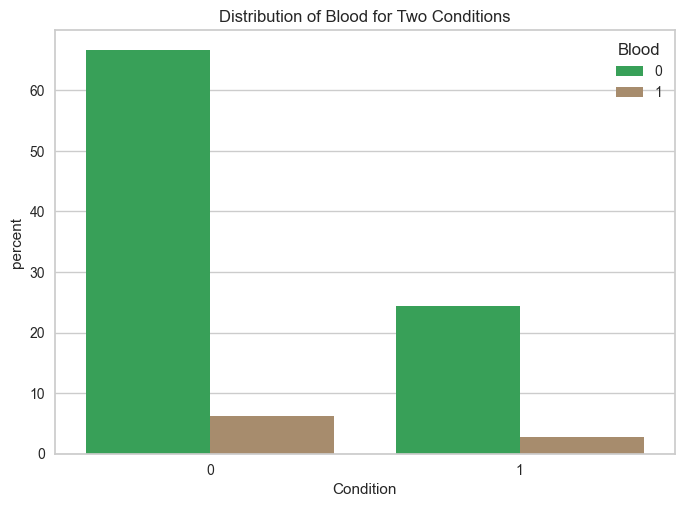

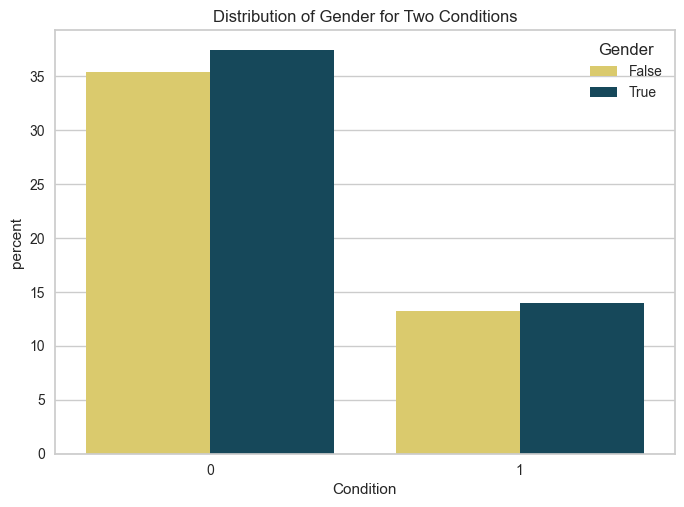

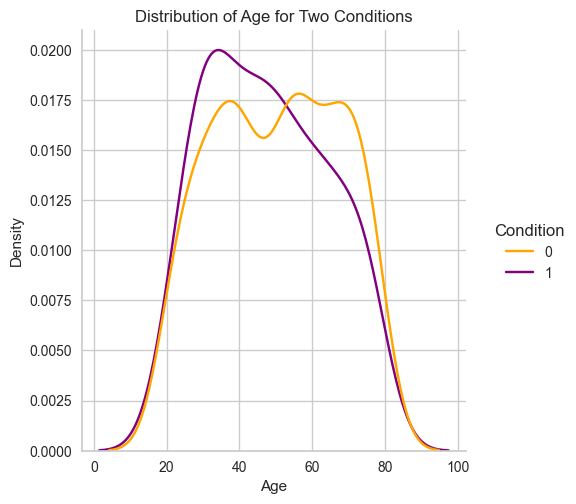

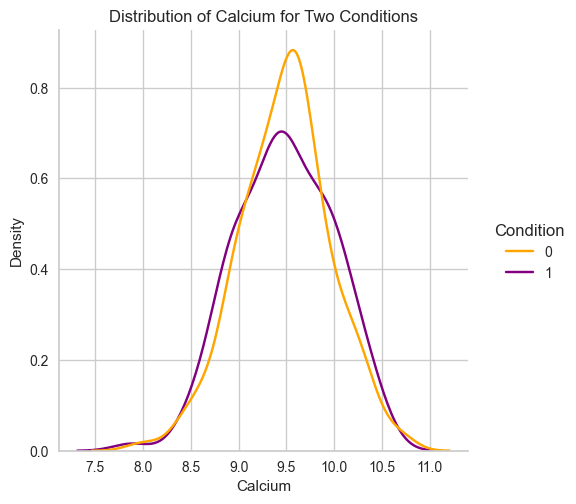

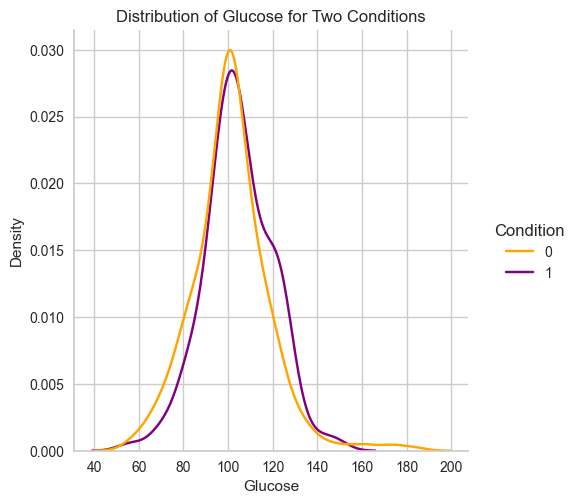

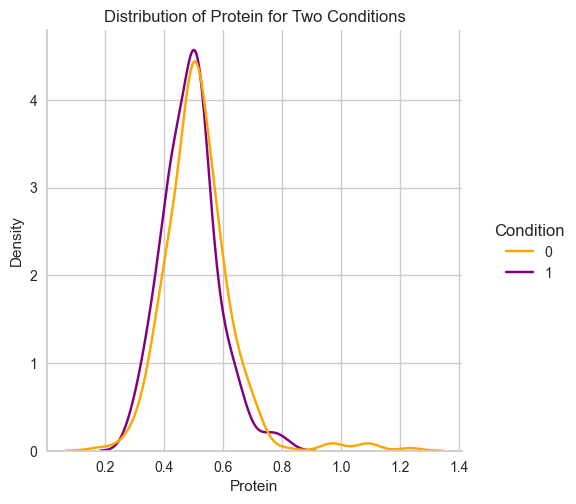

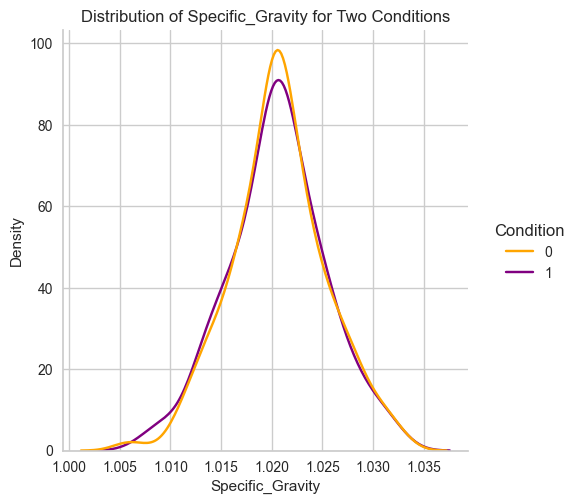

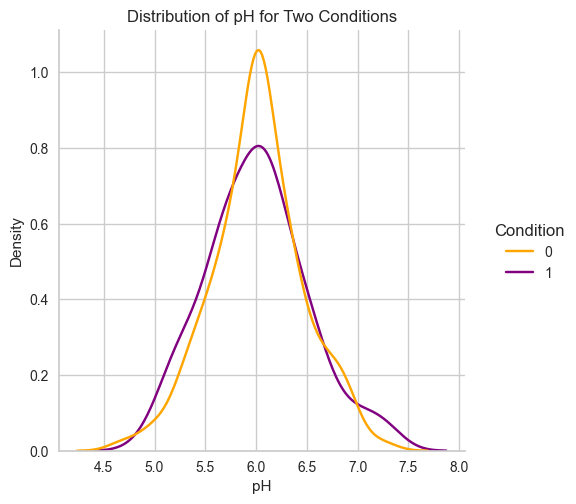

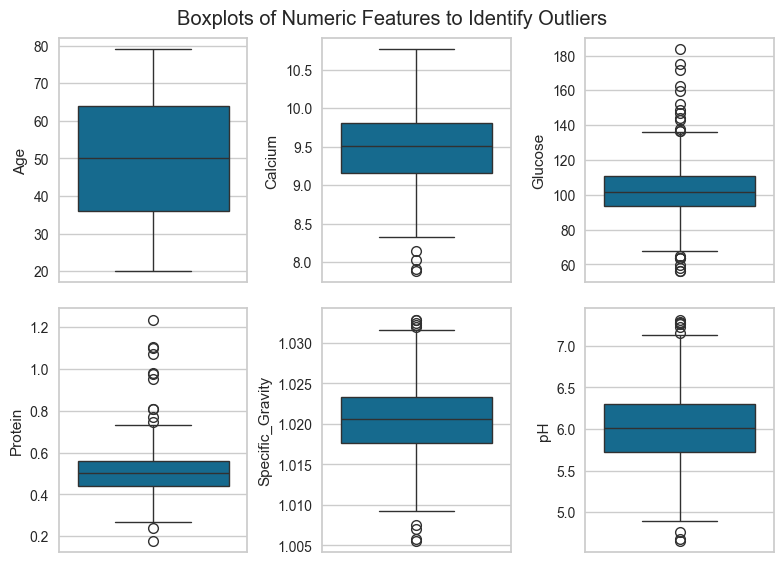

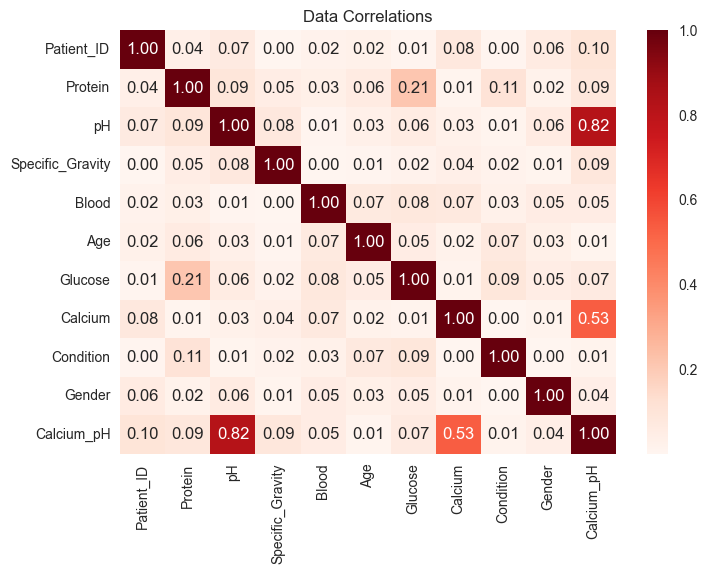

Did not remove, columns have low correlations.

Final Data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Patient_ID        500 non-null    int64  
 1   Protein           500 non-null    float64
 2   pH                500 non-null    float64
 3   Specific_Gravity  500 non-null    float64
 4   Blood             500 non-null    int64  
 5   Age               500 non-null    int64  
 6   Glucose           500 non-null    float64
 7   Calcium           500 non-null    float64
 8   Condition         500 non-null    int64  
 9   Gender            500 non-null    bool   
 10  Calcium_pH        500 non-null    float64
dtypes: bool(1), float64(6), int64(4)
memory usage: 39.7 KB


In [153]:
handler = DataHandler()
handler.load_data(data_path, 'Condition')
handler.get_info()
handler.clean_data()
handler.show_distributions()
handler.show_outliers()
handler.feature_engineering('Calcium_pH', handler.data['Calcium'] / handler.data['pH'])
handler.feature_selection_correlation(threshold=0.9)
print("\nFinal Data:\n")
handler.get_info()

# Modeling

### Data preparation 

In [154]:
df_model = df.copy()

# remove id column 
df_model =  df_model.drop('Patient_ID',axis=1)

# normalize
numeric_cols = [col for col in df_model.columns if col not in ['Blood', 'Gender', 'Condition']]
print(f"normalizing columns: {numeric_cols}")
numeric_df = df[numeric_cols]
scaler = StandardScaler()
normalized_df_data = scaler.fit_transform(numeric_df.values)
df_model[numeric_cols] = normalized_df_data

normalizing columns: ['Age', 'Protein', 'pH', 'Specific_Gravity', 'Glucose', 'Calcium', 'Calcium_pH', 'Risk']


In [155]:
# define helper functions 

def reset_and_concat(X, y):
    """
    Resets the index for both feature and target DataFrames and concatenates them along the columns.

    Parameters:
    X (pd.DataFrame): The DataFrame containing the features.
    y (pd.Series): The Series containing the target variable.

    Returns:
    pd.DataFrame: A DataFrame where features and target are combined, with the indices reset.
    """
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    return pd.concat([X, y], axis=1)

def get_X_y(df):
    """
    Separates the DataFrame into features (X) and target (y).

    Parameters:
    df (pd.DataFrame): The input DataFrame containing both features and the target.

    Returns:
    X (pd.DataFrame): The DataFrame containing all feature columns.
    y (pd.Series): The Series containing the target variable.
    """
    X = df.drop(['Condition'], axis=1)
    y = df['Condition']
    return X, y


In [156]:
# split data to train and text 
X, y = get_X_y(df_model)
X_train_initial, X_test_initial, y_train_initial, y_test_initial = train_test_split(X, y, test_size = 0.2, random_state=42)
print(f"size of train: {X_train_initial.shape}, size of test {X_test_initial.shape}")
print(f"data columns: {X_train_initial.columns.tolist()}")


# make df backs of train and test 
df_train = reset_and_concat(X_train_initial, y_train_initial)
df_test = reset_and_concat(X_test_initial, y_test_initial)

size of train: (400, 10), size of test (100, 10)
data columns: ['Age', 'Protein', 'pH', 'Specific_Gravity', 'Glucose', 'Calcium', 'Blood', 'Gender', 'Calcium_pH', 'Risk']


_As we saw before, data is highly unbalanced so the model will train on a balanced sample._

In [157]:
y_train_no_yes = y_train_initial.value_counts()
print(f"Target classes in train: {y_train_no_yes.values[0]}/{y_train_no_yes.values[1]}")

# upsample the minority class (with the condition)
df_majority = df_train[df_train['Condition']==0]
df_minority = df_train[df_train['Condition']==1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,   
                                 n_samples=y_train_no_yes[0],   
                                 random_state=42) 

df_train_up = pd.concat([df_majority, df_minority_upsampled])
df_train_up = df_train_up.reset_index(drop=True)

print(f"After upsampling: {df_train_up['Condition'].value_counts()[0]}/{df_train_up['Condition'].value_counts()[1]}")

Target classes in train: 284/116
After upsampling: 284/284


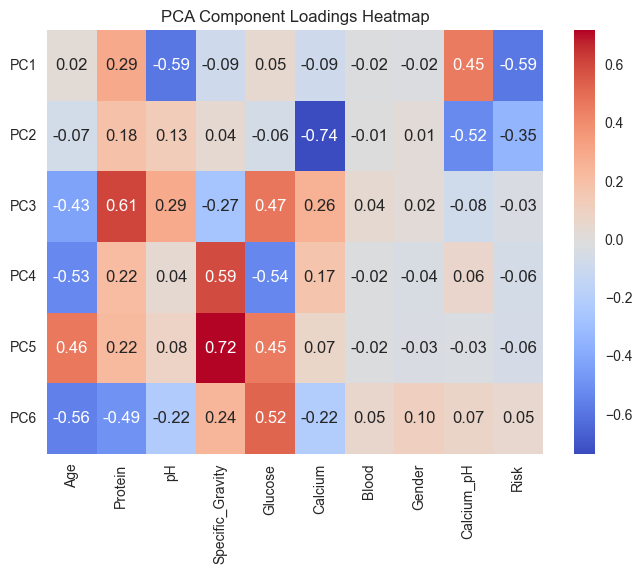

In [158]:
# perform pca 
X_train_up, y_train_up = get_X_y(df_train_up)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_up)
X_test_pca  = pca.transform(X_test_initial)
pca_components = pd.DataFrame(pca.components_, columns=X_train_up.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

# plot pca results 
plt.figure()
sns.heatmap(pca_components, annot=True, fmt=".2f", cmap='coolwarm')
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.title('PCA Component Loadings Heatmap')
plt.show()


* PC1: mainly about pH levels - with pH and Calcium_pH.
* PC2: Calcium and Calcium_pH, so this pc is the calcuim information.
* PC3: Protein and Glucose with an inverse relation to Age, possibly diet-related.
* PC4: Specific Gravity, with inverse Age and Glucose, maybe reflecting urine concentration.
* PC5: Similar to PC4, but age and clucose are in the other direction.
* PC6: Age and Protein, with an inverse relationship to Glucose, potentially related to metabolic health.


In [159]:
# organized train and test df after pca
pca_component_names = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)
X_train_pca.columns = pca_component_names
X_test_pca.columns = pca_component_names
df_train_pca = reset_and_concat(X_train_pca, y_train_up)
df_test_pca = reset_and_concat(X_test_pca, y_test_initial)

# split data into train and cross validation 
X_model, y_model = get_X_y(df_train_pca)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size = 0.2, random_state=42)
df_train_final = reset_and_concat(X_train, y_train)
df_val = reset_and_concat(X_val, y_val)

### Machine learning model

_Recent studies, highlight the effectiveness of machine learning models like XGBoost in the classification of kidney stone disease. This model is well-regarded for its ability to handle complex, structured data and has been applied successfully in clinical contexts for predicting kidney stone presence based on various physiological indicators._

Reference: <br>
* Sassanarakkit, Supatcha, Sudarat Hadpech, and Visith Thongboonkerd. <br> 
"Theranostic roles of machine learning in clinical management of kidney stone disease."  <br>
Computational and Structural Biotechnology Journal 21 (2023): 260-266.

In [160]:
# search best parameters of XGBoost classifier

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = XGBClassifier(eval_metric='logloss')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid, cv=cv, 
                           scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_:.2f}")

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.8}
Best Score: 0.81


In [161]:
# fit the best model
best_xgb_model = grid_search.best_estimator_

# test on the validation set 
y_pred = best_xgb_model.predict(X_val)
y_pred_proba = best_xgb_model.predict_proba(X_val)[:, 1] 
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation set accuracy: {accuracy:.2f}")

Validation set accuracy: 0.82


In [162]:
# define evaluation functions for plotting models' results

def plot_cm(cm, label="", cmap="PuRd"):
    """
    Plot a confusion matrix as a heatmap using Seaborn.

    Parameters:
    - cm: Confusion matrix to plot.
    - label: Optional label for the title to specify the model.
    - cmap: Color map for the heatmap. Default is "Reds".
    """
    sns.heatmap(cm, annot=True, cmap=cmap, fmt="d", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
    plt.title(f"{label} Confusion Matrix Heatmap")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_roc(y, y_proba1, y_proba_2=None, label_1="", label_2=""):
    """
    Plot ROC curves for one or two models.

    Parameters:
    - y: True labels.
    - y_proba1, label_1: Predicted probabilities and label of the first model.
    - y_proba1, label_1: Predicted probabilities and label of the second model (or none).

    """
    plt.figure(figsize=(8, 6))
    
    # Plot ROC for the first model
    fpr, tpr, _ = roc_curve(y, y_proba1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orchid', lw=2, label=f'{label_1} AUC = {roc_auc:.2f}')

    # Plot ROC for the second model if provided
    if y_proba_2 is not None:
        fpr2, tpr2, _ = roc_curve(y, y_proba_2)
        roc_auc2 = auc(fpr2, tpr2)
        plt.plot(fpr2, tpr2, color='green', lw=2, label=f'{label_2} AUC = {roc_auc2:.2f}')
    
    # Plotting the random classifier line
    plt.plot([0, 1], [0, 1], color='seagreen', lw=2, linestyle='--')
    
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='best')
    plt.show()

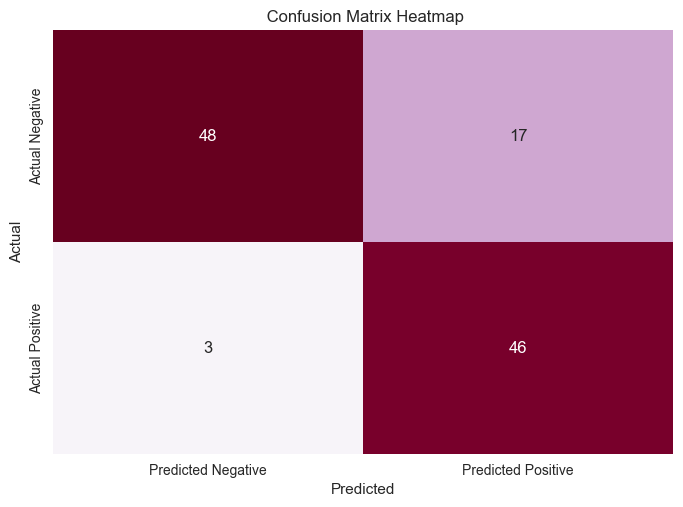

In [163]:
cm = confusion_matrix(y_val, y_pred)
plot_cm(cm)

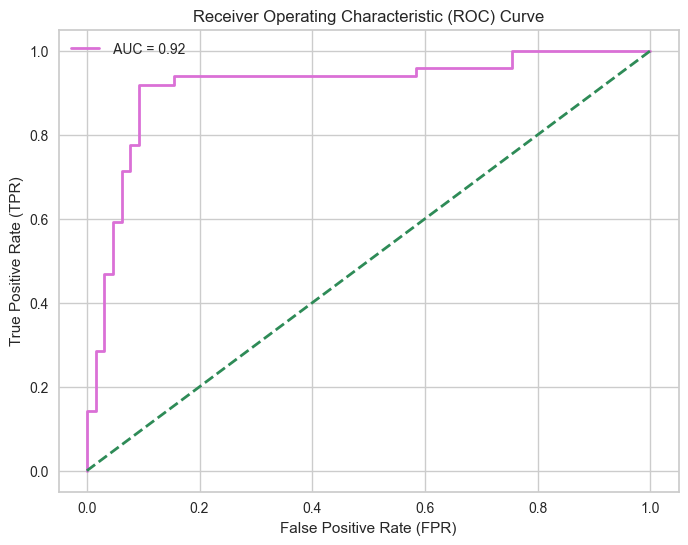

In [164]:
plot_roc(y_val, y_pred_proba)

_The XGBoost model performed well overall but with some false positives._

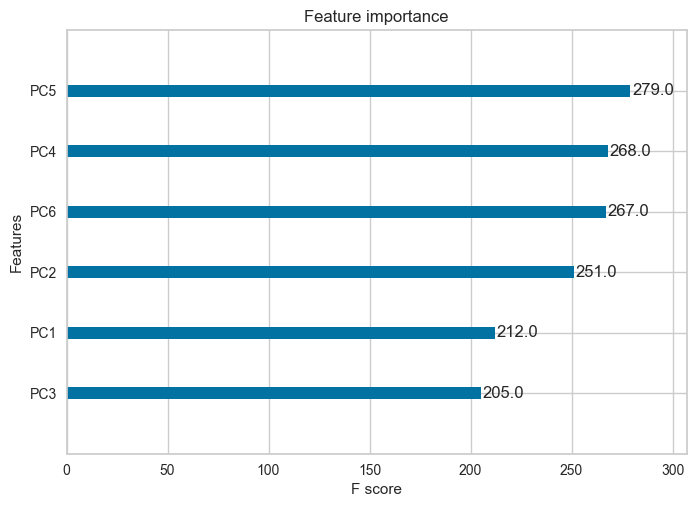

In [165]:
plot_importance(best_xgb_model)
plt.show()

_The most important features for classification were related to the later PCs. PC4 and PC5 with information about specific gravity, age, and glucose, and PC6, about age and protein. Another key component was related to calcium._

# Auto ML

_Let's proceed to use automated methods to identify the best-performing model._

In [166]:
from pycaret.classification import *

s = setup(df_train_final, target = 'Condition', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Condition
2,Target type,Binary
3,Original data shape,"(454, 7)"
4,Transformed data shape,"(454, 7)"
5,Transformed train set shape,"(317, 7)"
6,Transformed test set shape,"(137, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [167]:
# compare multiple models and select the best one
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7892,0.8724,0.7574,0.8319,0.7874,0.5791,0.5888,0.0290
rf,Random Forest Classifier,0.7513,0.8566,0.8007,0.7434,0.7675,0.5005,0.5086,0.0350
gbc,Gradient Boosting Classifier,0.7135,0.8201,0.8000,0.7065,0.7437,0.4219,0.4372,0.0270
xgboost,Extreme Gradient Boosting,0.7102,0.8148,0.7816,0.7024,0.7356,0.4167,0.4265,0.2910
dt,Decision Tree Classifier,0.7066,0.7029,0.8246,0.6902,0.7422,0.4075,0.4314,0.0060
lightgbm,Light Gradient Boosting Machine,0.7039,0.7903,0.7820,0.6940,0.7316,0.4031,0.4112,0.1630
ada,Ada Boost Classifier,0.6780,0.7285,0.7382,0.6750,0.7006,0.3531,0.3622,0.0280
ridge,Ridge Classifier,0.6114,0.6376,0.6871,0.6111,0.6408,0.2162,0.2247,0.0060
lda,Linear Discriminant Analysis,0.6114,0.6376,0.6871,0.6111,0.6408,0.2162,0.2247,0.0060
lr,Logistic Regression,0.6083,0.6368,0.6812,0.6089,0.6371,0.2102,0.2185,2.8980


In [168]:
best

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

_The best model is Extra Trees Classifier, which is similar to XGBoost in that both use ensemble methods and decision trees, but the building of the tree is different. Extra Trees uses a bagging approach, where each tree is trained independently,  and XGBoost uses boosting, where trees are built sequentially to correct the errors of the previous trees._

In [169]:
# tune best model
tuned_model = tune_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6250,0.6392,0.8824,0.6000,0.7143,0.2227,0.2604
1,0.6250,0.7059,0.7059,0.6316,0.6667,0.2411,0.2431
2,0.5625,0.6157,0.4706,0.6154,0.5333,0.1351,0.1395
3,0.7500,0.8196,0.8235,0.7368,0.7778,0.4941,0.4981
4,0.6875,0.8789,0.7500,0.6667,0.7059,0.3750,0.3780
5,0.7500,0.8086,0.8125,0.7222,0.7647,0.5000,0.5040
6,0.6250,0.7461,0.6875,0.6111,0.6471,0.2500,0.2520
7,0.5484,0.6292,0.4375,0.5833,0.5000,0.1033,0.1069
8,0.7097,0.7500,0.6250,0.7692,0.6897,0.4224,0.4304


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [170]:
print("Train set accuracy")
predictions = predict_model(tuned_model, data=df_train_final)
print("Validation set accuracy")
predictions = predict_model(tuned_model, data=df_val)

Train set accuracy


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9471,0.9907,0.9447,0.9528,0.9487,0.8942,0.8942


Validation set accuracy


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8246,0.9207,0.8776,0.7544,0.8113,0.6491,0.6556


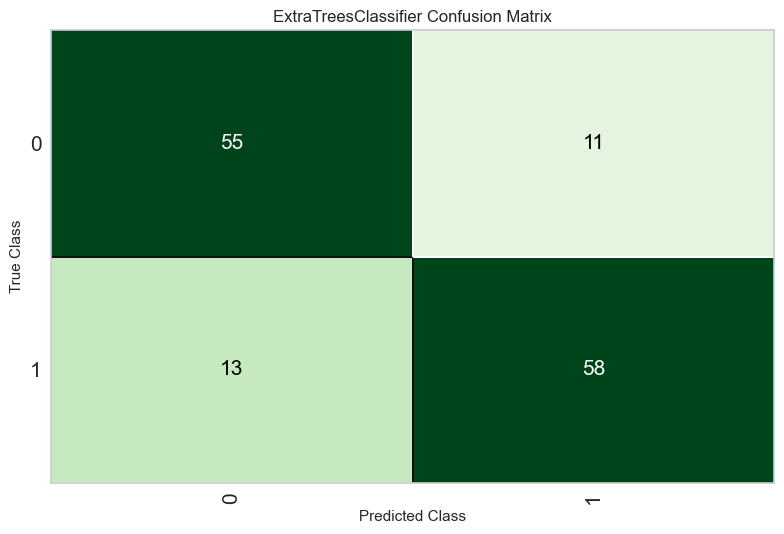

In [171]:
plot_model(tuned_model, plot='confusion_matrix')

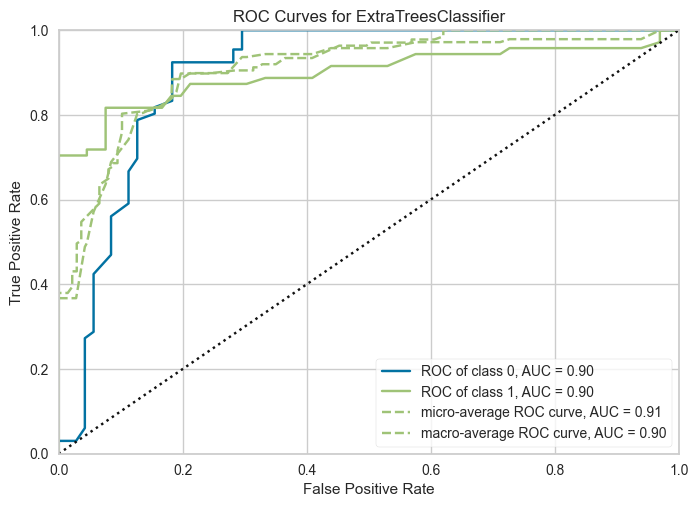

In [172]:
plot_model(tuned_model, plot='auc')

_This model is performing well overall, but the decrease in performance from training to validation is concerning and suggests potential overfitting._

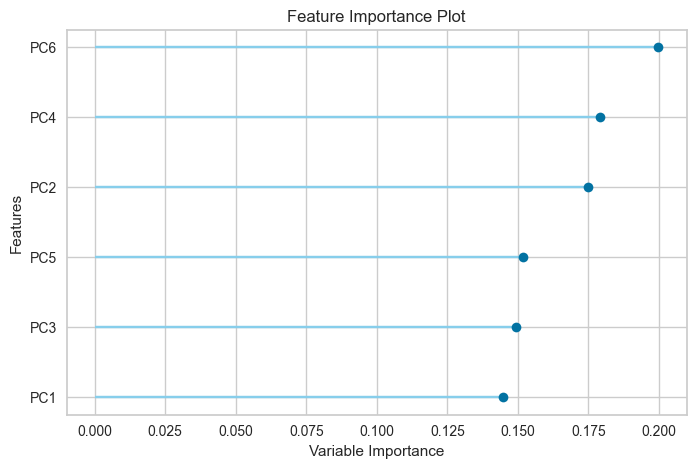

In [173]:
plot_model(tuned_model, plot='feature')

_The most important feature is PC6, associated with age and protein, with an inverse contribution from glucose. PC4, involving age, glucose, and specific gravity, along with PC2, which is related to calcium, are also significant. Interestingly, PC6 and PC4 showed high importance across both models._

In [174]:
# finilize model (retrain on validation set)
automl_model = finalize_model(tuned_model)
predictions = predict_model(automl_model, data=df_val)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9123,0.9614,0.9388,0.8679,0.9020,0.8228,0.8249


# Model Compaison using the Test Set

In [175]:
X_test, y_test = get_X_y(df_test_pca)

# Predict with XGBoost model
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# Predict with AutoML model
y_pred_automl = predict_model(automl_model, data=df_test_pca)['prediction_label']
y_pred_proba_automl = predict_model(automl_model, data=df_test_pca)['prediction_score']

# Calculate accuracy, AUC, and confusion matrix for both models
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_automl = accuracy_score(y_test, y_pred_automl)

auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
auc_automl = roc_auc_score(y_test, y_pred_proba_automl)

conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
conf_matrix_automl = confusion_matrix(y_test, y_pred_automl)

print(f"XGBoost - Accuracy: {accuracy_xgb:.2f}, AUC: {auc_xgb:.2f}")
print(f"AutoML - Accuracy: {accuracy_automl:.2f}, AUC: {auc_automl:.2f}")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7900,0.4097,0.1000,0.4000,0.1600,0.0870,0.1147


XGBoost - Accuracy: 0.69, AUC: 0.47
AutoML - Accuracy: 0.79, AUC: 0.62


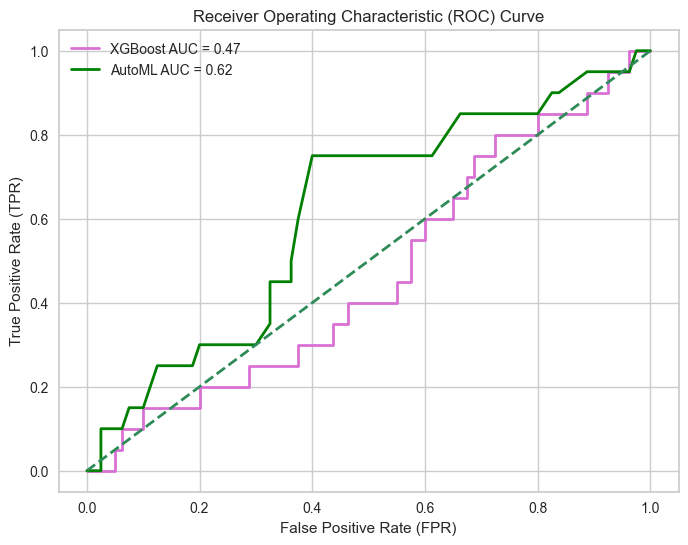

In [176]:
plot_roc(y_test, y_pred_proba_xgb, y_pred_proba_automl, "XGBoost", "AutoML")

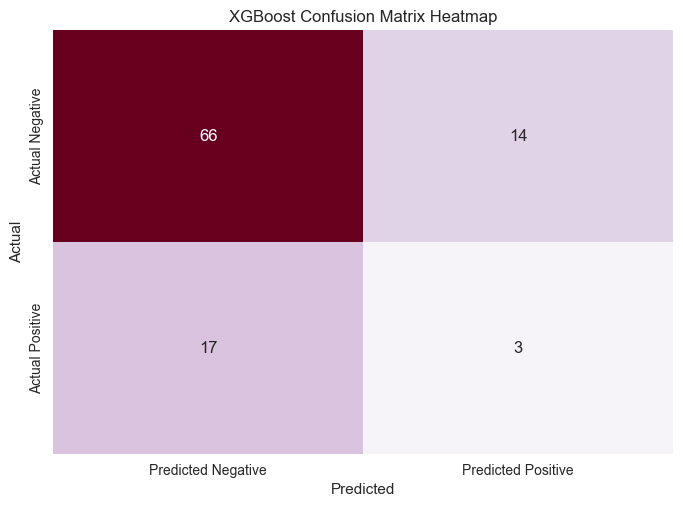

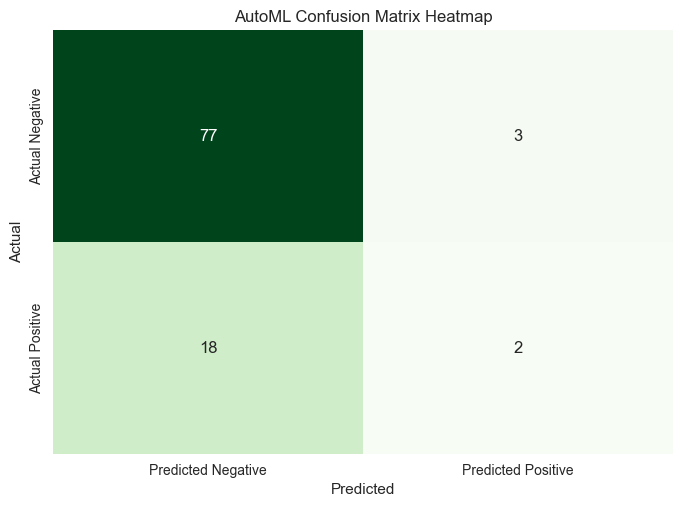

In [177]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plot_cm(cm_xgb, "XGBoost")

cm_automl = confusion_matrix(y_test, y_pred_automl)
plot_cm(cm_automl, "AutoML", "Greens")

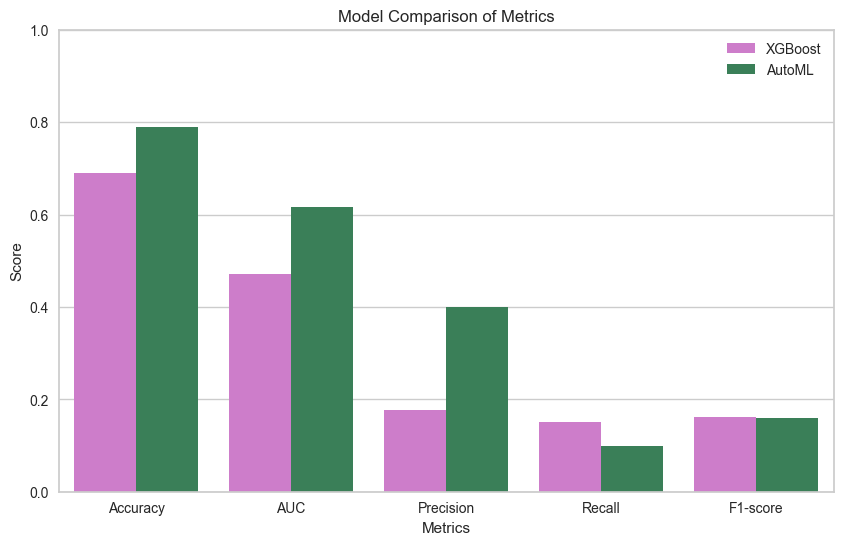

In [178]:
y_pred_list = [y_pred_xgb, y_pred_automl]

metrics = {
    'Model': ['XGBoost', 'AutoML'],
    'Accuracy': [accuracy_xgb, accuracy_automl],
    'AUC': [auc_xgb, auc_automl], 
    'Precision': [precision_score(y_test, y_pred) for y_pred in y_pred_list],
    'Recall': [recall_score(y_test, y_pred) for y_pred in y_pred_list],
    'F1-score': [f1_score(y_test, y_pred) for y_pred in y_pred_list]
}

metrics_df = pd.DataFrame(metrics)
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Plotting the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_melted, palette=['orchid', 'seagreen'])

plt.title('Model Comparison of Metrics')
plt.ylim(0, 1)  # Assuming all metrics are between 0 and 1
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.legend(loc='best')
plt.show()

_Based on the confusion matrix, ROC curves, and other metrics, both models display lower accuracy and AUC on the new dataset. The AutoML model shows a strong bias towards predicting the healthy class, resulting in a lower recall. Both models suffer from low F1-scores._